## Boostrap

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from   tqdm import tqdm

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FOMCDrift/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from Regression import Regression

In [3]:
df_tmp = Regression().prep_regression()

In [4]:
def _ols(df: pd.DataFrame, in_sample_ratio: float) -> pd.DataFrame: 
    
    df_tmp = (df.sample(
        frac = in_sample_ratio))
    
    model = (sm.OLS(
        endog = df_tmp.PX_bps,
        exog  = sm.add_constant(df_tmp.drop(columns = ["PX_bps"]))).
        fit())
    
    params = model.params
    alpha  = params["const"]
    
    df_param = (params.to_frame(
        name = "beta").
        reset_index().
        rename(columns = {"index": "variable"}))
    
    df_out = (df.reset_index().melt(
        id_vars = ["event", "PX_bps"]).
        merge(right = df_param, how = "inner", on = ["variable"]).
        assign(beta_val = lambda x: x.beta * x.value).
        pivot(index = ["event", "PX_bps"], columns = "variable", values = "beta_val").
        sum(axis = 1).
        to_frame(name = "predict").
        reset_index().
        assign(signal_rtn = lambda x: np.sign(x.predict) * x.PX_bps))
    
    return df_out

def _bootstrap_ols(df: pd.DataFrame, sims: int, in_sample_ratio: float) -> pd.DataFrame: 
    
    df_tmp = df.drop(columns = [
        "variable"])

    df_exog = (df_tmp.query(
        "day == -4").
        drop(columns = ["date", "day", "PX_bps"]).
        fillna(0))

    df_endog = (df_tmp.query(
        "-3 <= day <= -1")
        [["event", "PX_bps"]].
        groupby("event").
        agg("mean"))

    df_combined = (df_endog.merge(
        right = df_exog, how = "inner", on = ["event"]).
        set_index("event"))
    
    df_date = (df_tmp.query(
        "day == -1")
        [["date", "event"]])
    
    df_out = (pd.concat([
        _ols(df_combined, in_sample_ratio).assign(sim = i + 1) 
        for i in range(sims)]).
        merge(right = df_date, how = "inner", on = ["event"]))
    
    return df_out


sims: int = 100
in_sample_ratio: float = 0.15

df_out = (df_tmp.query(
    "day != [0,1]").
    groupby("variable").
    apply(_bootstrap_ols, sims, in_sample_ratio).
    reset_index().
    drop(columns = ["level_1"]))

<AxesSubplot:xlabel='date'>

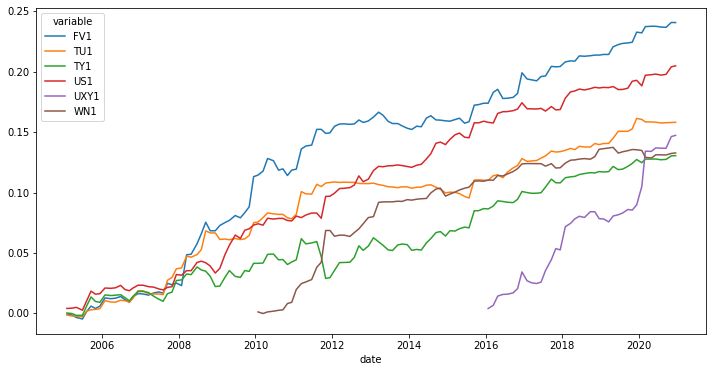

In [5]:
(df_out[
    ["variable", "signal_rtn", "date"]].
    groupby(["date", "variable"]).
    agg("mean").
    reset_index().
    pivot(index = "date", columns = "variable", values = "signal_rtn").
    cumsum().
    plot(
        figsize = (12,6)))

In [6]:
def _get_ols_rtn(df: pd.DataFrame, sample_size: float) -> pd.DataFrame:
    
    df_sample = (df.sample(
        frac = 0.7).
        set_index("event").
        drop(columns = ["variable"]))
    
    model = (sm.OLS(
        endog = df_sample.PX_bps,
        exog  = sm.add_constant(df_sample.drop(columns = ["PX_bps"]))).
        fit())
    
    df_input = (df.set_index(
        "event").
        drop(columns = ["variable", "PX_bps"]))
    
    df_out = (model.predict(
        exog = sm.add_constant(df_input)).
        to_frame(name = "predicted_rtn"))
    
    return df_out

In [7]:
def _bootstrap_regression(df: pd.DataFrame, n_sims: int, sample_size: float) -> pd.DataFrame:
    
    df_exog = (df.query(
        "day == -4").
        drop(columns = ["date", "day", "PX_bps"]).
        fillna(0))

    df_endog = (df.query(
        "-3 <= day <= -1")
        [["event", "PX_bps"]].
        groupby("event").
        agg("mean"))

    df_combined = (df_exog.merge(
        right = df_endog, how = "inner", on = ["event"]))
    
    df_sim_rtn = (pd.concat([
        _get_ols_rtn(df_combined, sample_size).assign(sim = i + 1) 
        for i in tqdm(range(n_sims), desc = "{} Sampled OLS".format(df.name))]))

    df_signal_rtn = (df.query(
        "-3 <= day <= -1")
        [["event", "date", "PX_bps"]].
        merge(right = df_sim_rtn, how = "inner", on = ["event"]).
        assign(signal_bps = lambda x: np.sign(x.predicted_rtn) * x.PX_bps))
    
    return df_signal_rtn

def sample_ols(sample_size: float = 0.7, n_sims: int = 1_000) -> pd.DataFrame:

    df_prep = Regression().prep_regression()
    df_out  = (df_prep.groupby(
        "variable").
        apply(_bootstrap_regression, n_sims, sample_size).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_out

df_sample_rtn = sample_ols()

WN1 Sampled OLS: 100%|█████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 86.62it/s]


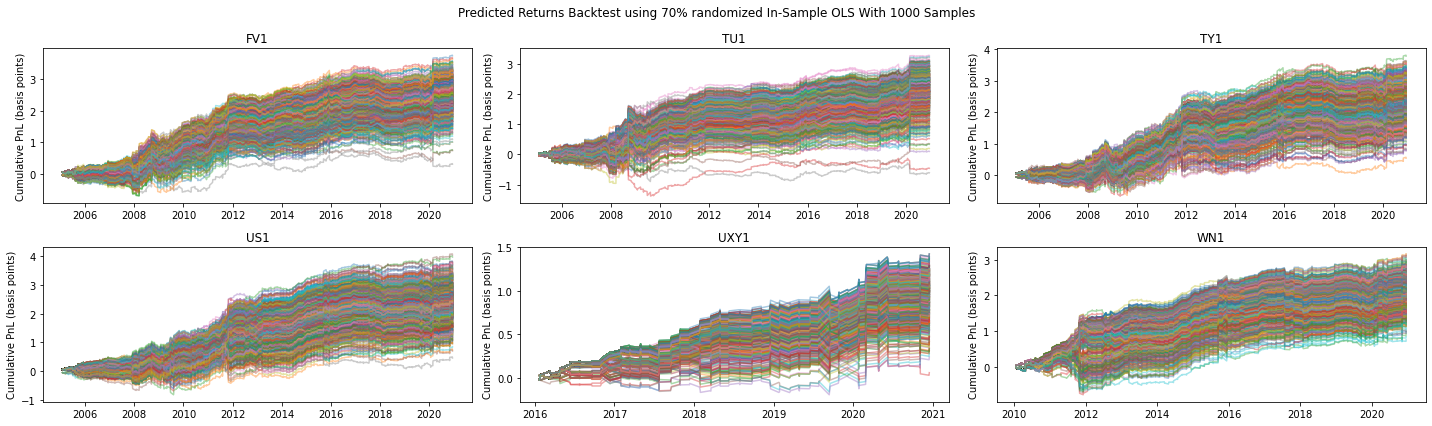

In [8]:
def plot_simulated_rtn(df_sample_rtn: pd.DataFrame, sample_size: float, n_sims: int) -> plt.Figure: 
    
    variables = df_sample_rtn.variable.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()): 

        (df_sample_rtn.query(
            "variable == @variable").
            pivot(index = "date", columns = "sim", values = "signal_bps").
            cumsum().
            plot(
                ax     = ax,
                alpha  = 0.4,
                legend = False,
                xlabel = "",
                title  = variable,
                ylabel = "Cumulative PnL (basis points)"))

    fig.suptitle("Predicted Returns Backtest using {}% randomized In-Sample OLS With {} Samples".format(
        int(sample_size * 100),
        n_sims))
    plt.tight_layout()
    
plot_simulated_rtn(df_sample_rtn, 0.7, 1_000)

In [9]:
def get_mean_median_rtn(df_sample_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_sample_rtn[
        ["variable", "date", "signal_bps"]].
        groupby(["variable", "date"]).
        agg(["mean", "median"])
        ["signal_bps"].
        reset_index())
    
    return df_out

df_mean_median_rtn = get_mean_median_rtn(df_sample_rtn)

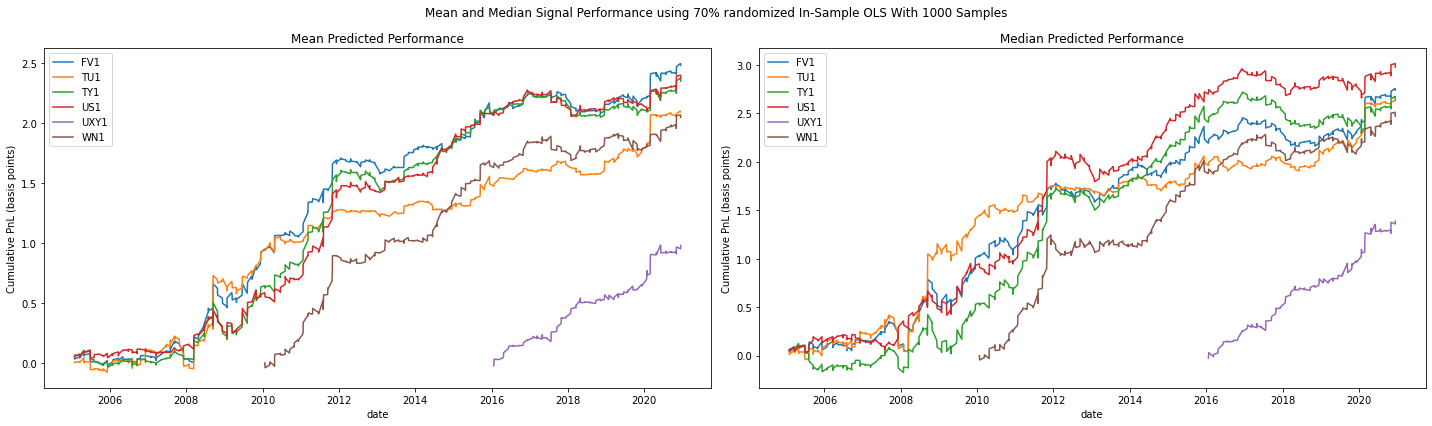

In [10]:
def plot_mean_median_rtn(df_mean_median_rtn: pd.DataFrame, n_sims: int = 1_000, sample_size: float = 0.7) -> plt.Figure:

    df_longer = (df_mean_median_rtn.rename(
        columns = {"variable": "security"}).
        melt(id_vars = ["security", "date"]))

    variables = df_longer.variable.drop_duplicates()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()):

        (df_longer.query(
            "variable == @variable").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "value").
            cumsum().
            plot(
                ax     = ax,
                ylabel = "Cumulative PnL (basis points)",
                title  = "{} Predicted Performance".format(variable.capitalize())))

    fig.suptitle("Mean and Median Signal Performance using {}% randomized In-Sample OLS With {} Samples".format(
        int(sample_size * 100),
        n_sims))

    plt.tight_layout()
    
plot_mean_median_rtn(df_mean_median_rtn)

In [22]:
def get_sample_sharpe(df_sample_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_sample_sharpe = (df_sample_rtn[
        ["variable", "sim", "signal_bps"]].
        groupby(["variable", "sim"]).
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8)).
        reset_index())
    
    return df_sample_sharpe

df_sample_sharpe = get_sample_sharpe(df_sample_rtn)

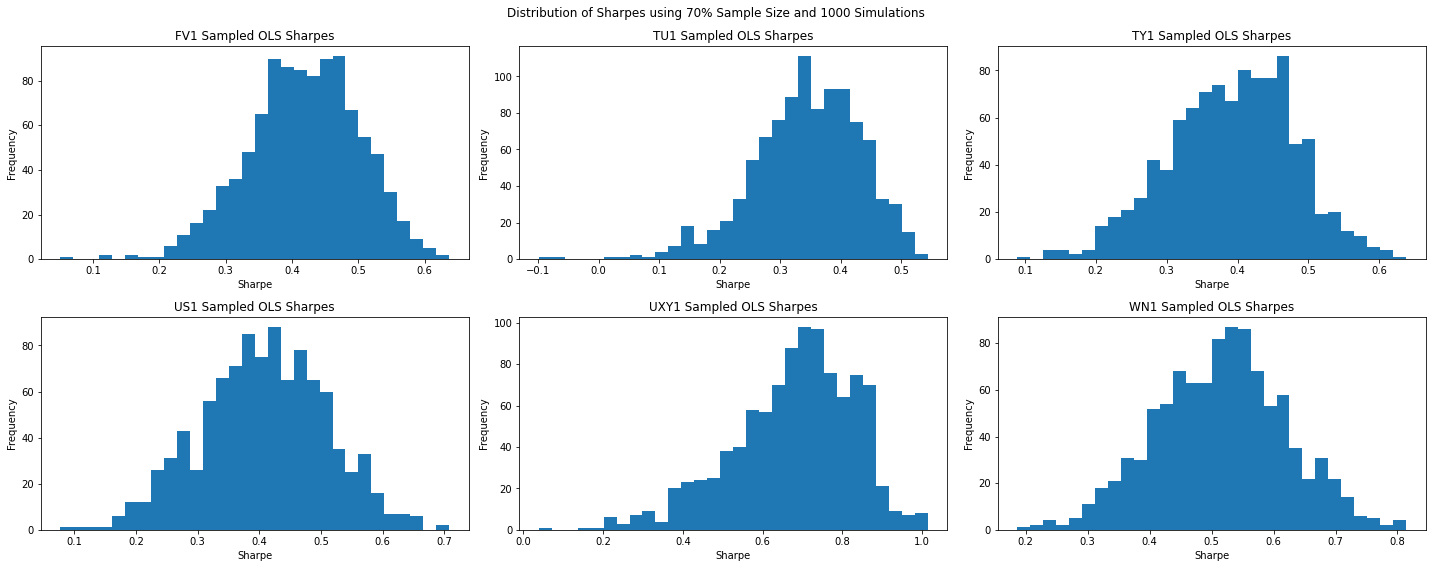

In [23]:
def plot_sample_sharpe_dist(df_sample_sharpe: pd.DataFrame, sample_size: float = 0.7, n_sims: int = 1000) -> plt.Figure: 
    
    variables = df_sample_sharpe.variable.drop_duplicates()
    fig, axes = plt.subplots(ncols = len(variables) // 2, nrows = len(variables) // 3, figsize = (20,8))

    for variable, ax in zip(variables, axes.flatten()):

        (df_sample_sharpe.query(
            "variable == @variable").
            sharpe.
            plot(
                kind   = "hist",
                bins   = 30,
                ax     = ax,
                xlabel = "Sharpe",
                title  = variable + " Sampled OLS Sharpes"))

    fig.suptitle("Distribution of Sharpes using {}% Sample Size and {} Simulations".format(
        int(sample_size * 100),
            n_sims))
    
    plt.tight_layout()
    
plot_sample_sharpe_dist(df_sample_sharpe)

In [13]:
def get_worst_sharpe_sim(df_sample_sharpe: pd.DataFrame, df_sample_rtn: pd.DataFrame) -> pd.DataFrame:
    
    df_out = (df_sample_sharpe[
        ["variable", "sharpe"]].
        groupby("variable").
        agg("min").
        merge(right = df_sample_sharpe, how = "inner", on = ["sharpe"]).
        merge(right = df_sample_rtn, how = "inner", on = ["variable", "sim"]))
    
    return df_out

df_worst_sharpe = get_worst_sharpe_sim(df_sample_sharpe, df_sample_rtn)

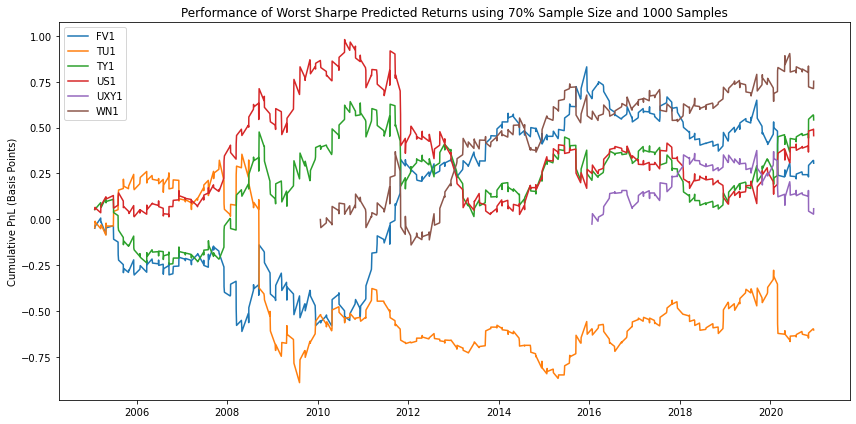

In [15]:
def plot_worst_sharpe(df_worst_sharpe: pd.DataFrame, sample_size: float = 0.7, n_sims: int = 1_000) -> plt.Figure: 
    
    (df_worst_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "signal_bps").
        cumsum().
        plot(
            xlabel  = "",
            figsize = (12,6),
            ylabel  = "Cumulative PnL (Basis Points)",
            title   = "Performance of Worst Sharpe Predicted Returns using {}% Sample Size and {} Samples".format(
                int(sample_size * 100),
                n_sims)))
    
    plt.tight_layout()
    
plot_worst_sharpe(df_worst_sharpe)

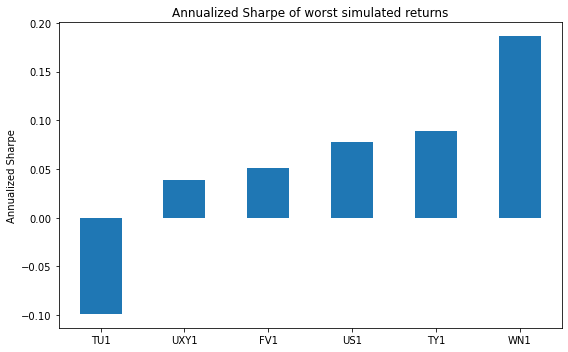

In [21]:
def plot_worst_shapre(df_worst_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_worst_sharpe[
        ["variable", "signal_bps"]].
        groupby("variable").
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8)).
        sort_values("sharpe")
        [["sharpe"]].
        plot(
            kind    = "bar",
            legend  = False,
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of worst simulated returns",
            rot     = 0,
            figsize = (8,5)))
    
    plt.tight_layout()
    
plot_worst_shapre(df_worst_sharpe)

In [17]:
def _get_percentile(df: pd.DataFrame, percentile: float) -> pd.DataFrame:

    df_out = (df.assign(
        percentile = lambda x: x.sharpe.rank(pct = True)).
        query("percentile == 0.1"))
    
    return df_out
    
def get_percentile_sharpe(df_sample_sharpe: pd.DataFrame, percentile: float = 0.1) -> pd.DataFrame: 
    
    df_out = (df_sample_sharpe.groupby(
        "variable").
        apply(_get_percentile, percentile).
        reset_index(drop = True).
        merge(right = df_sample_rtn, how = "inner", on = ["variable", "sim"]))
    
    return df_out

df_percentile_sharpe = get_percentile_sharpe(df_sample_sharpe)

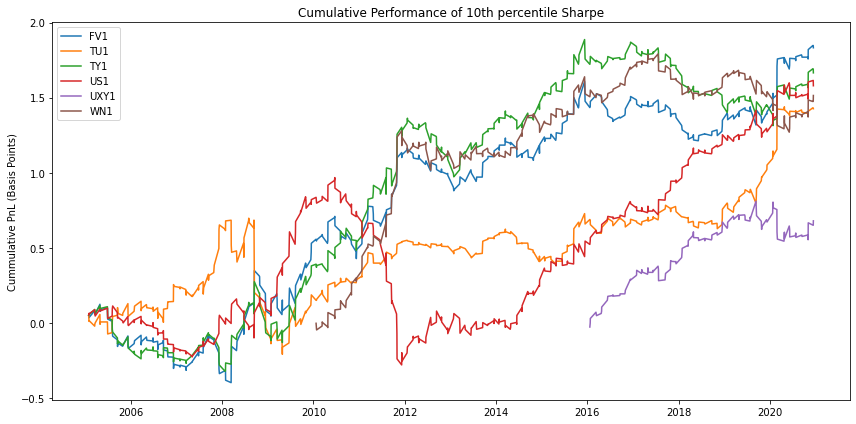

In [18]:
def plot_percentile_sharpe(df_percentile_sharpe: pd.DataFrame) -> plt.Figure:
    
    (df_percentile_sharpe.rename(
        columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "signal_bps").
        cumsum().
        plot(
            ylabel  = "Cummulative PnL (Basis Points)",
            xlabel  = "",
            title   = "Cumulative Performance of 10th percentile Sharpe",
            figsize = (12,6)))
    
    plt.tight_layout()

plot_percentile_sharpe(df_percentile_sharpe)

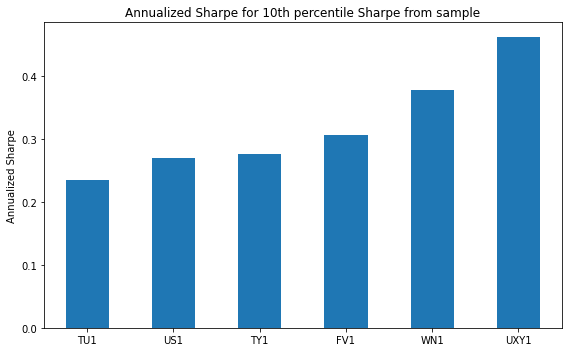

In [20]:
def plot_percentile_sharpe(df_percentile_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_percentile_sharpe[
        ["variable", "signal_bps"]].
        groupby("variable").
        agg(["mean", "std"])
        ["signal_bps"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(8)).
        sort_values("sharpe")
        [["sharpe"]].
        plot(
            kind    = "bar",
            rot     = 0,
            xlabel  = "",
            legend  = False,
            figsize = (8,5),
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe for 10th percentile Sharpe from sample"))
    
    plt.tight_layout()
    
plot_percentile_sharpe(df_percentile_sharpe)